# [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)


本文来自kaggle GM gunesevitan的[教程](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410)

学习本教程前，建议先熟悉numpy、pandas的使用，这里推荐官方文档。

本教程详细演示了数据挖掘的一般流程：

1. 数据探索性分析（Exploratory Data Analysis， EDA）
2. 数据处理及特征工程
3. 数据划分与验证
4. 建模

## **任务简介**

**Titanic: Machine Learning from Disaster** 是 Kaggle 上非常经典的问题。 这个入门级的案例更关注于 **探索性数据分析** （EDA: Exploratory Data Analysis） 和 **特征工程**（Feature Engineering）。
**Titanic: Machine Learning from Disaster** 需要我们把领域知识应用到特征工程，所以我们在做特征工程时也收集了一些关于泰坦尼克号的知识。 在泰坦尼克号的数据集里面隐藏了很多的“秘密”，我们将尝试地去从中找出一些影响泰坦尼克号的乘客最终成为遇难者还是幸存者的隐藏“秘密”，但是可能还有其他的一些原因仍然等待我们去发现。

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

* 训练集（training set） 有 **891** 行 而 测试集（test set） 有 **418** 行
* 训练集有 **12** 个特征（feature） 而 测试集 有 **11** 个特征
* 训练集中额外的特征是目标变量 `Survived` 

In [2]:
def concat_df(train_data, test_data):
    # 拼接训练集和测试集，结果就是更多行的 dataframe，是为了后面对特征的处理方便，训练集和测试集可以一起操作了。
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # 从合并的 dataframe 中分离出训练集和测试集
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape))
print('Test X Shape = {}'.format(df_test.shape))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = (891,)

Test X Shape = (418, 11)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


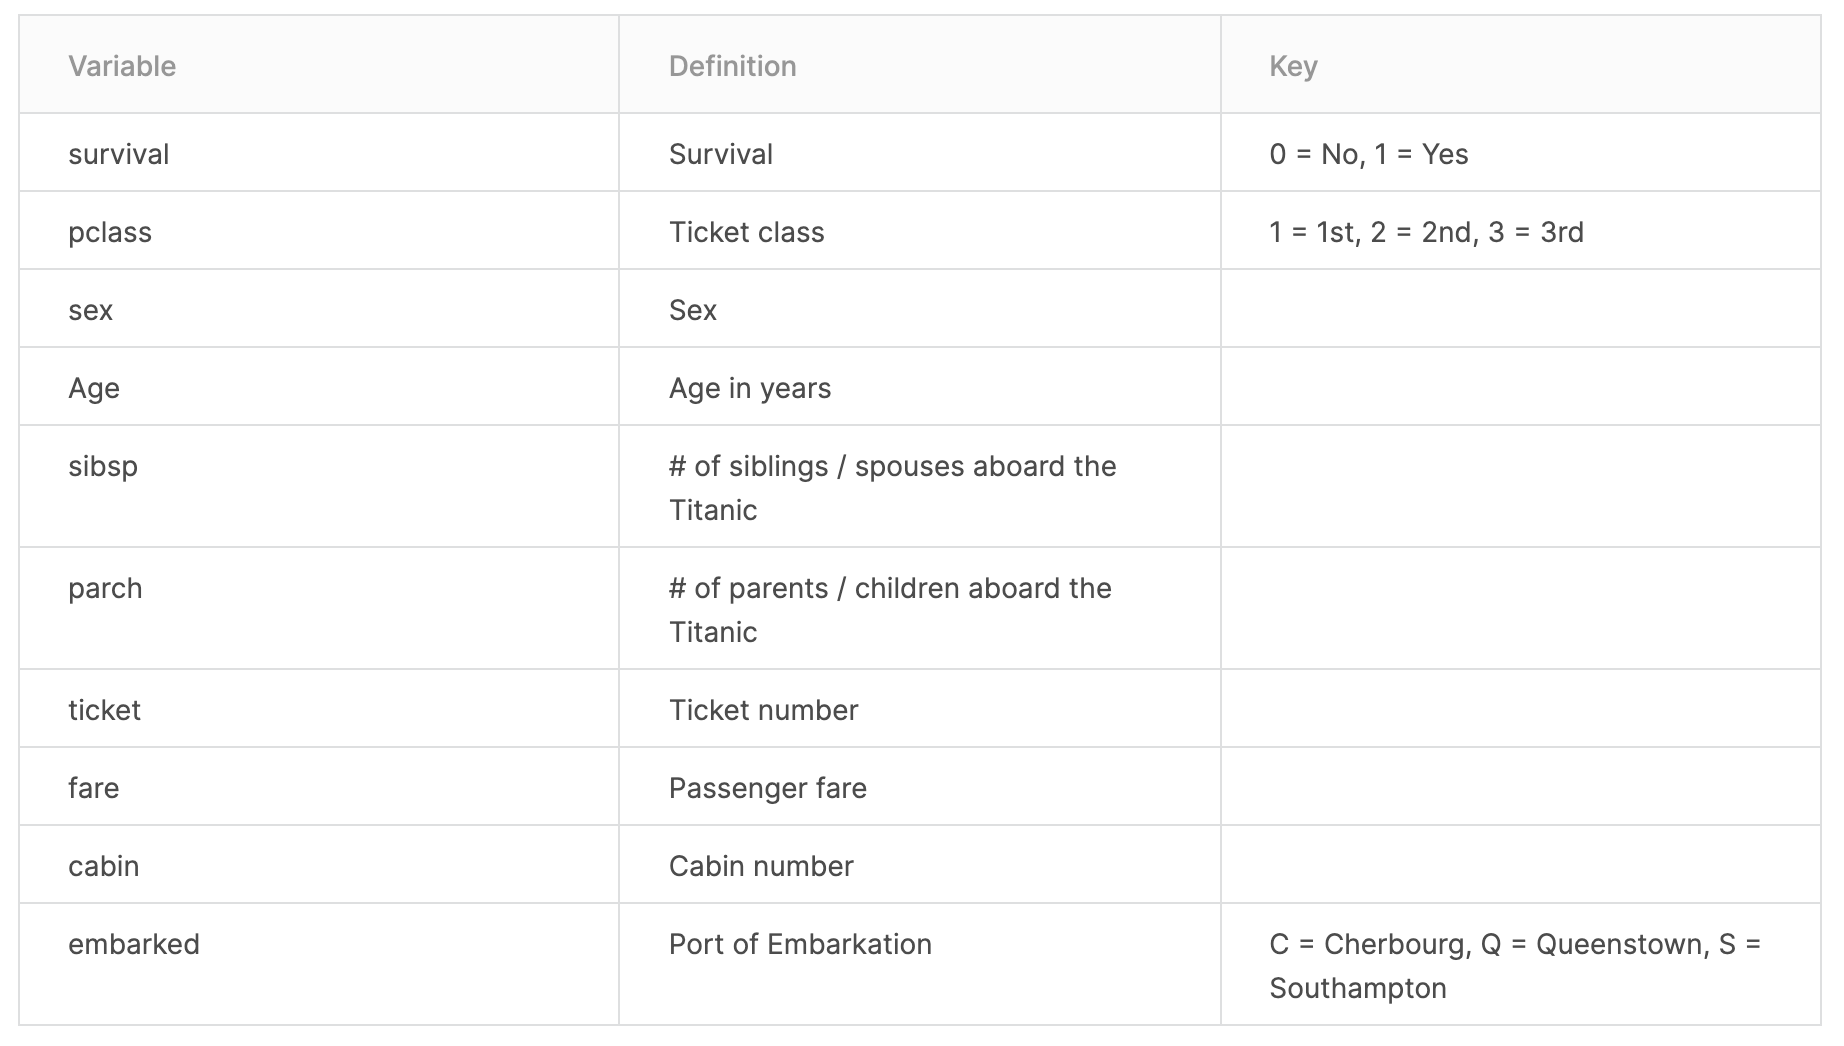

## **数据分析**

### **1.1 Overview**
在进行具体的数据分析和挖掘之前，首先进行数据预处理操作
* `PassengerId` 是每一行的唯一ID，0它对目标（Survived）是没有任何影响的。
* `Survived` 是我们尝试去预测的目标变量 (**0** 或 **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) 是每个乘客的社会经济地位，它是序号编码的分类特征, 共有如下3个特征：
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` 和 `Age` 即字面意思。
* `SibSp` 是该乘客的兄弟姐妹和配偶的总数
* `Parch` 是该乘客父母和子女的总数
* `Ticket` 是该乘客的船票票号
* `Fare` 是该乘客的票价
* `Cabin` 是该乘客的客舱编号
* `Embarked` 是该乘客上船的港口，它是一个类别特征且有如下三个值(**C**、**Q** 、 **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [11]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


PassengerId  Survived  Pclass  \
556          557         1       1   
814          815         0       3   
312          313         0       2   

                                                  Name     Sex   Age  SibSp  \
556  Duff Gordon, Lady. (Lucille Christiana Sutherl...  female  48.0      1   
814                         Tomlin, Mr. Ernest Portage    male  30.5      0   
312              Lahtinen, Mrs. William (Anna Sylfven)  female  26.0      1   

     Parch  Ticket   Fare Cabin Embarked  
556      0   11755  39.60   A16        C  
814      0  364499   8.05   NaN        S  
312      1  250651  26.00   NaN        S

In [12]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


PassengerId  Pclass                         Name     Sex   Age  SibSp  \
41           933       1  Franklin, Mr. Thomas Parham    male   NaN      0   
173         1065       3             Torfa, Mr. Assad    male   NaN      0   
86           978       3           Barry, Miss. Julia  female  27.0      0   

     Parch  Ticket     Fare Cabin Embarked  
41       0  113778  26.5500   D34        S  
173      0    2673   7.2292   NaN        C  
86       0  330844   7.8792   NaN        Q

### **1.2 Missing Values**
就我们上面观察数据样本时发现有些特征是有缺失值的。`display_missing` 方法能够显示训练集和测试集中每一列的缺失值数量。
* 训练集在`Age`、`Cabin` 和 `Embarked` 中有缺失值。
* 测试集在`Age`、`Cabin` 和 `Fare` 中有缺失值。
因为我们之前已经把训练集和测试集拼接成一个更多行的 dataframe，所以现在同时处理训练集和测试集的缺失值就方便多了。`Age`, `Embarked` and `Fare` 的缺失值数量相比样本总数来说是比较少的, 但是`Cabin`中大概有 **80%** 的样本是缺失的。我们可以用一些描述性统计指标去填充在`Age`, `Embarked` 和 `Fare` 中的缺失值，如众数、平均数等，但是对于 `Cabin` 这些方法就不管用了.

In [13]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




#### **1.2.1 Age**
`Age` 中的缺失值可以用中位数来填充，但是用整个数据集的`Age`中位数并不是一个好的选择。更好的选择是用该乘客所属的 Pclass 组内的`Age`中位数来填充缺失值，因为它和`Age`以及`Survived` 都有较高的关联性。

In [14]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

Feature 1    Feature 2  Correlation Coefficient
6        Age          Age                 1.000000
9        Age       Pclass                 0.408106
17       Age        SibSp                 0.243699
22       Age         Fare                 0.178740
25       Age        Parch                 0.150917
29       Age     Survived                 0.077221
41       Age  PassengerId                 0.028814

为了更准确的填充 `Age` 的缺失值，`Sex` 特征应当是我们以 `Pclass` 来分组后要继续分组的特征。说起来有点绕，看下面的代码输出结果，以`Pclass`和`Sex`分组后，它们分别有不同的年龄中位数。当乘客的社会阶级增加，男性和女性的年龄中位数都增加了，但是女性往往有更低的年龄中位数。所以我们现在有了更好的年龄缺失值填充方式。

In [15]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


#### **1.2.2 Embarked**
`Embarked` 是个类别特征，整个数据集只有两条缺失值需要处理。两个乘客都是女性，她们有相同的社会阶层和票号。这意味着她们认识彼此，并且在相同的港口上船。

In [16]:
df_all[df_all['Embarked'].isnull()]

Age Cabin Embarked  Fare                                       Name  \
61   38.0   B28      NaN  80.0                        Icard, Miss. Amelie   
829  62.0   B28      NaN  80.0  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId  Pclass     Sex  SibSp  Survived  Ticket  
61       0           62       1  female      0       1.0  113572  
829      0          830       1  female      0       1.0  113572

Google 了一下 **Stone, Mrs. George Nelson (Martha Evelyn)**, 发现她和她的女仆**Amelie Icard**从 **S (Southampton)**港口上船。[Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*

根据这条 Google 到的信息，`Embarked` 的缺失值用 **S**来填充

In [17]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### **1.2.3 Fare**
`Fare` 只有一条缺失值. 我们假设`Fare` 是和家庭人数有关的(`Parch` and `SibSp`) a和 `Pclass` 特征. 取“没有家庭成员且社会阶级属于的第三阶级的男性”分组的`Fare`中位数可能是用来填充缺失值的好方法。

In [18]:
df_all[df_all['Fare'].isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
1043  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket  
1043       3  male      0       NaN   3701

In [19]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### **1.2.4 Cabin**
`Cabin` 特征需要一丢丢技巧来发现更多的信息。`Cabin` 特征的缺失值占总样本的大多数，但是它又不能完全的被忽略掉，因为客舱位置可能能反应出更高的生存概率。`Cabin` 值的首字母是用表示甲板，代表客舱所在的甲板位置。那些甲板主要是分隔不同的乘客类别，但是其中一些甲板的客舱住着不同类别的乘客。
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* 在船甲板处，有 6 个房间被编号为 **T, U, W, X, Y, Z**，但是仅有 **T** 客舱在数据集中出现了。
* **A**、 **B** 和 **C** 甲板仅为第一等级乘客提供。
* **D** 和 **E** 为所有等级的乘客提供。
* **F** 和 **G** 仅为二等和三等的乘客提供。
* 从 A 到 G，离楼梯的距离越来越远，这可能是影响幸存的原因之一。

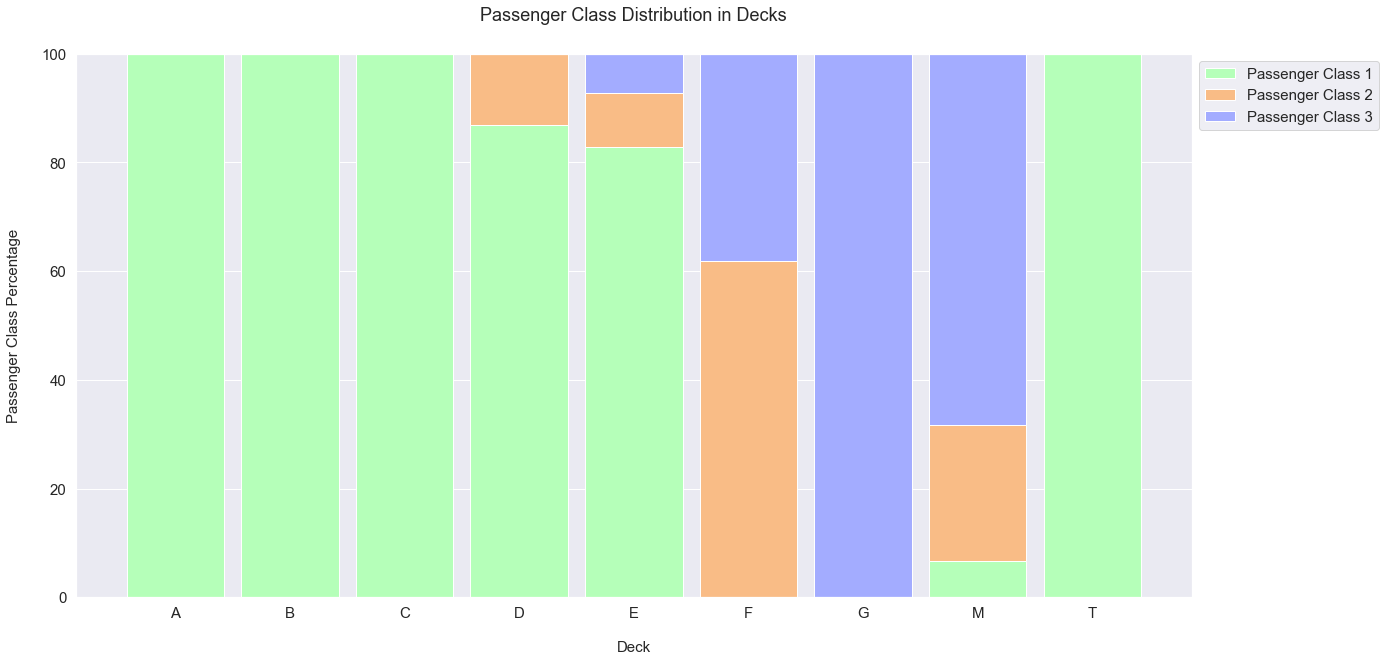

In [20]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

* **A**, **B** 和 **C** 甲板 **100%** 都是第一等级的乘客
* **D** 甲板有 **87%** 第一等级乘客和 **13%** 的第二等级乘客
* **E** 甲板有 **83%** 第一等级乘客, **10%** 的第二等级乘客和 **7%** 的第三等级乘客
* **F** 甲板有 **62%** 第二等级乘客和 **38%** 的第三等级乘客
* **G** 甲板全是第三等级的乘客
* 只有唯一一个乘客在船甲板的 **T** 客舱内，并且他是第一等级的乘客。**T** 客舱的乘客和 **A** 甲板的乘客最为相似，所以他被归到了 **A** 甲板。
* `Cabin`特征缺失的乘客将被标记为值 **M** (Missing), 因为这也找不到其他合适的值来填充。

In [21]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

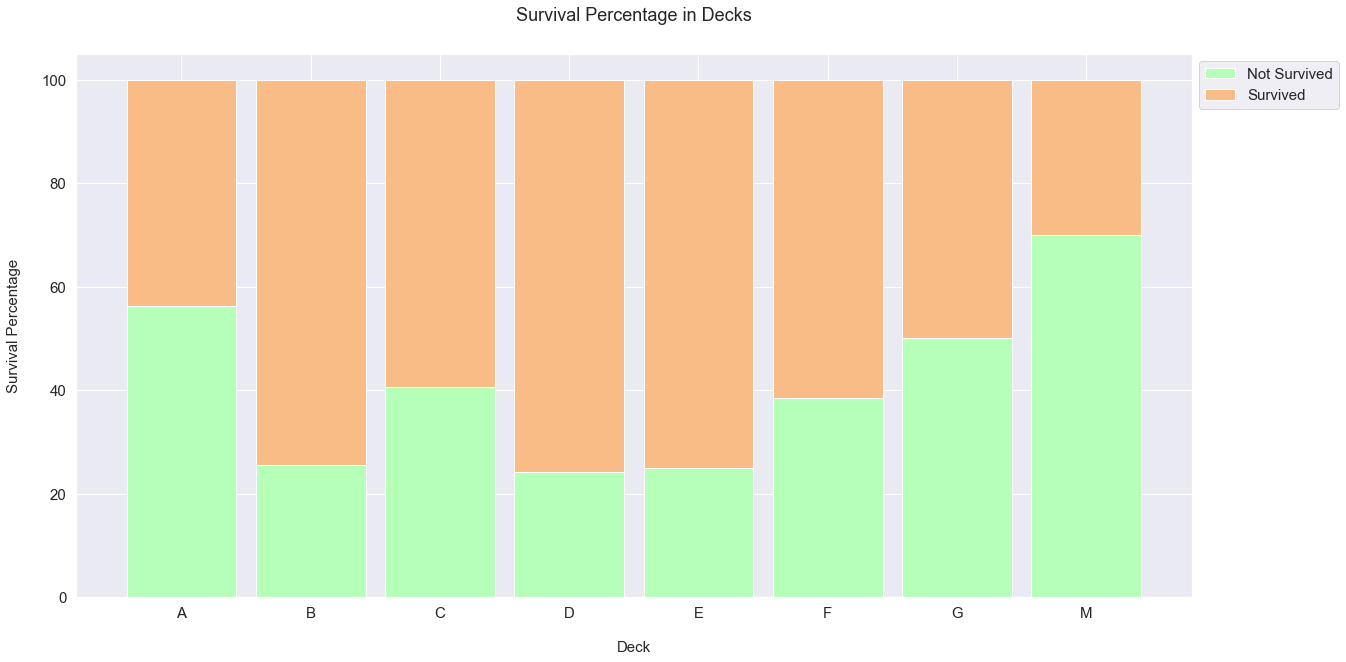

In [22]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

就和我们之前假设的一致，每一个甲板都有着不同的幸存率，所以这个特征是不能被忽视的。甲板 **B**, **C**, **D** and **E** 有着最高的幸存率。这些甲板里几乎都住着第一等级的乘客。甲板 **M** 的幸存率是最低的，这里充斥着第二、第三等级的乘客。我们可以猜测 **M** （缺失 `Cabin`值）的原因是很难收集到遇难者的该信息。所以，我们把 **M** 作为缺失值的填充值也是有道理的。`Deck` 特征有很多的类别，现在我们需要把它们其中一些类别基于它们的相似性归为一组。
* **A**、 **B** 和 **C** 被归为 **ABC** ，因为这些甲板仅安排了第一等级的乘客。
* **D** 和 **E** 甲板被归为 **DE** ，因为它们都有相似的乘客等级分布和相同的幸存率。
* **F** 和 **G** 甲板被归为 **FG** ，原因同上。
* **M** 甲板不需要被归到其他组中，因为它和其他组明显不一样，而且有最低的幸存率。

In [23]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

经过我们上面对 `Age`, `Embarked`, `Fare` and `Deck` 这些特征缺失值的填充,现在训练集和测试集都没有缺失值了，而 `Cabin`我们不再需要，因为我们根据它构造了更好的特征 `Deck` 。

In [24]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


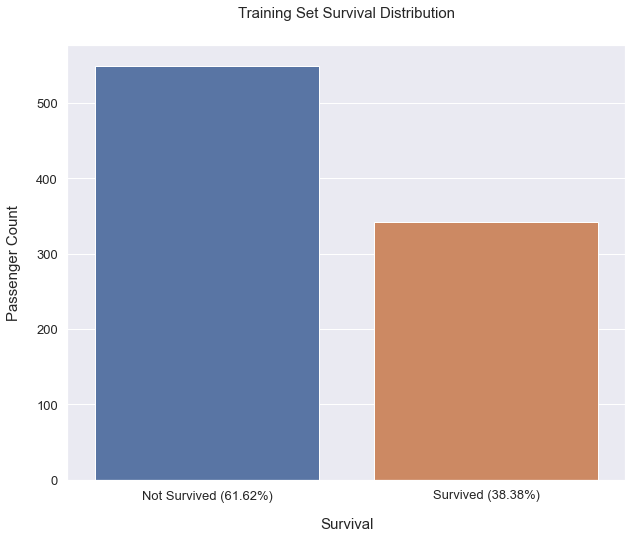

In [25]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### **1.4 Correlations**
特征之间可能会彼此高度相关。`Fare` 和 `Pclass`之间的相关性是最高的，其在训练集达到 **0.549500**，在测试集达到 **0.577147** 。其他特征的相关性也较高，在训练集中有 9 个特征相关性高于 **0.1** ，而测试集中有 **6** 个。

> # 问题：相关性多高才算认为是高度相关？
0-0.09为没有相关，0.1-0.3为弱相关，0.3-0.5为中等相关，0.5-1.0为强相关

In [26]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [27]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

Feature 1 Feature 2  Correlation Coefficient
6     Pclass      Fare                 0.549500
8     Pclass       Age                 0.417667
10     SibSp     Parch                 0.414838
12  Survived    Pclass                 0.338481
14  Survived      Fare                 0.257307
16     SibSp       Age                 0.249747
18     Parch      Fare                 0.216225
20       Age     Parch                 0.176733
22     SibSp      Fare                 0.159651
24       Age      Fare                 0.124061

In [28]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

Feature 1 Feature 2  Correlation Coefficient
6       Fare    Pclass                 0.577489
8        Age    Pclass                 0.526789
10       Age      Fare                 0.345347
12     SibSp     Parch                 0.306895
14      Fare     Parch                 0.230410
16     SibSp      Fare                 0.172032

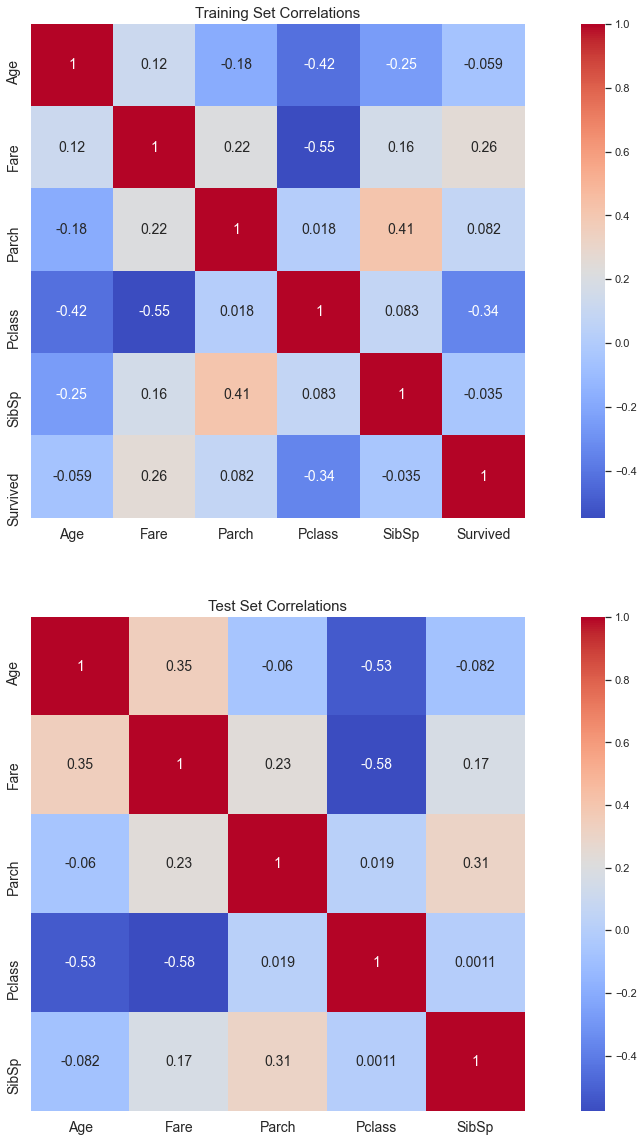

In [29]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### **1.5 Target Distribution in Features**

#### **1.5.1 Continuous Features**
这两个连续特征（`Age`和`Fare`）都有很好的分割点和尖峰，可以给决策树学习。而这两个特征可能的问题是，它们在训练集中有很好的分割点和尖峰，但是在测试集中它们的数据分布却更平滑了。这样训练出来的模型可能不能很好地泛化到测试集。
* `Age` 的分布显示出15岁以下的孩子比其他年龄段的有更高的幸存率。
* 在 `Fare` 特征分布中，分布尾部的存活率较高。由于异常值非常大，分布也具有正偏斜。

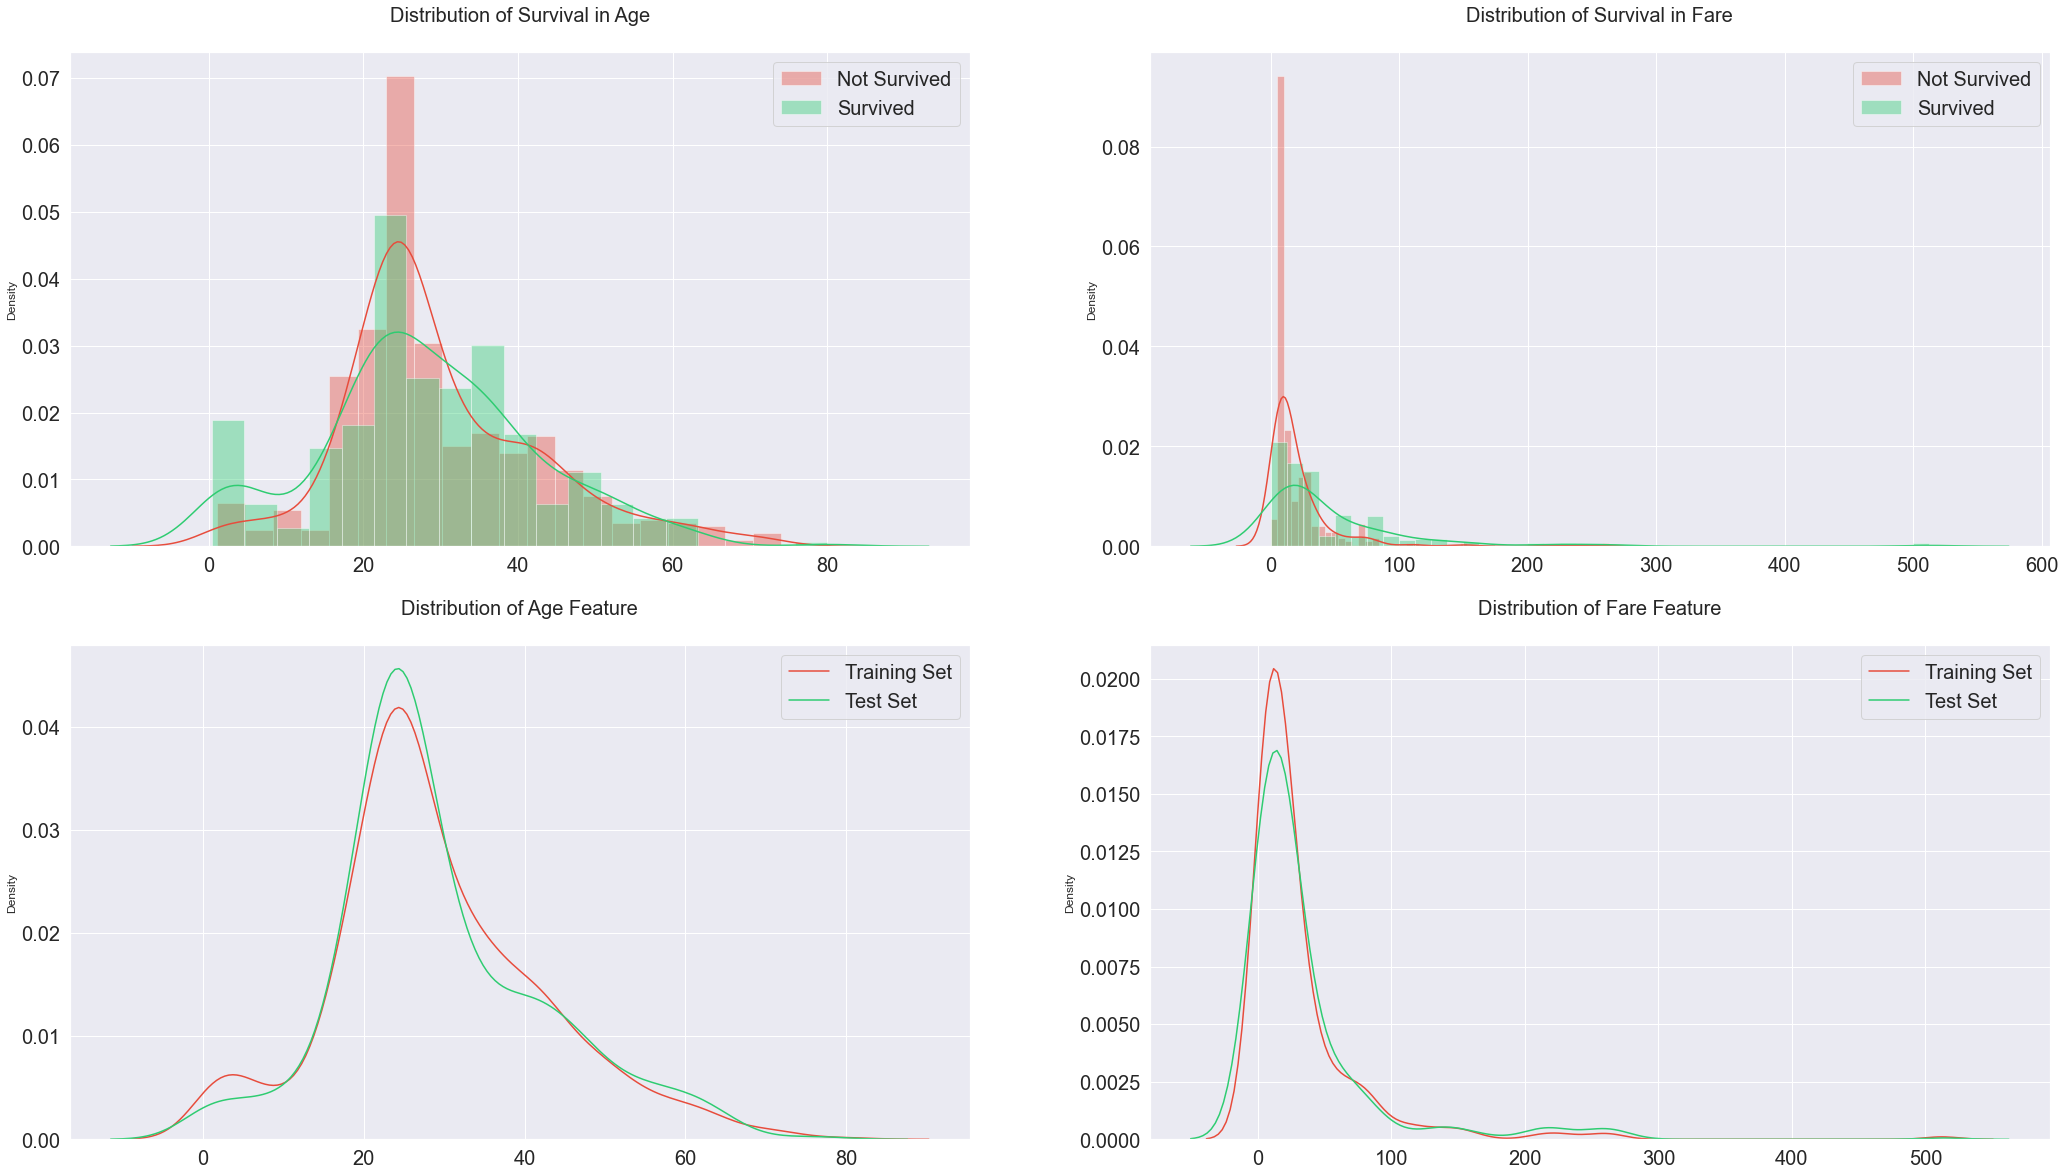

In [30]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

#### **1.5.2 Categorical Features**
每个分类特征至少有一类具有高死亡率。这些类别对于预测乘客是幸存者还是受害者非常有帮助。最好的分类特征是'Pclass'和'Sex'，因为它们具有最同质的分布。
从**Southampton**港口上船的乘客比从其他港口上船的乘客有更低的幸存率。从 **Cherbourg** 港口上船的乘客有超过一半的幸存。这种情况可能和 `Pclass` 有关。
* `Parch` 和 `SibSp` 这两个特征显示出只有一个家庭成员的乘客有着更高的幸存率。

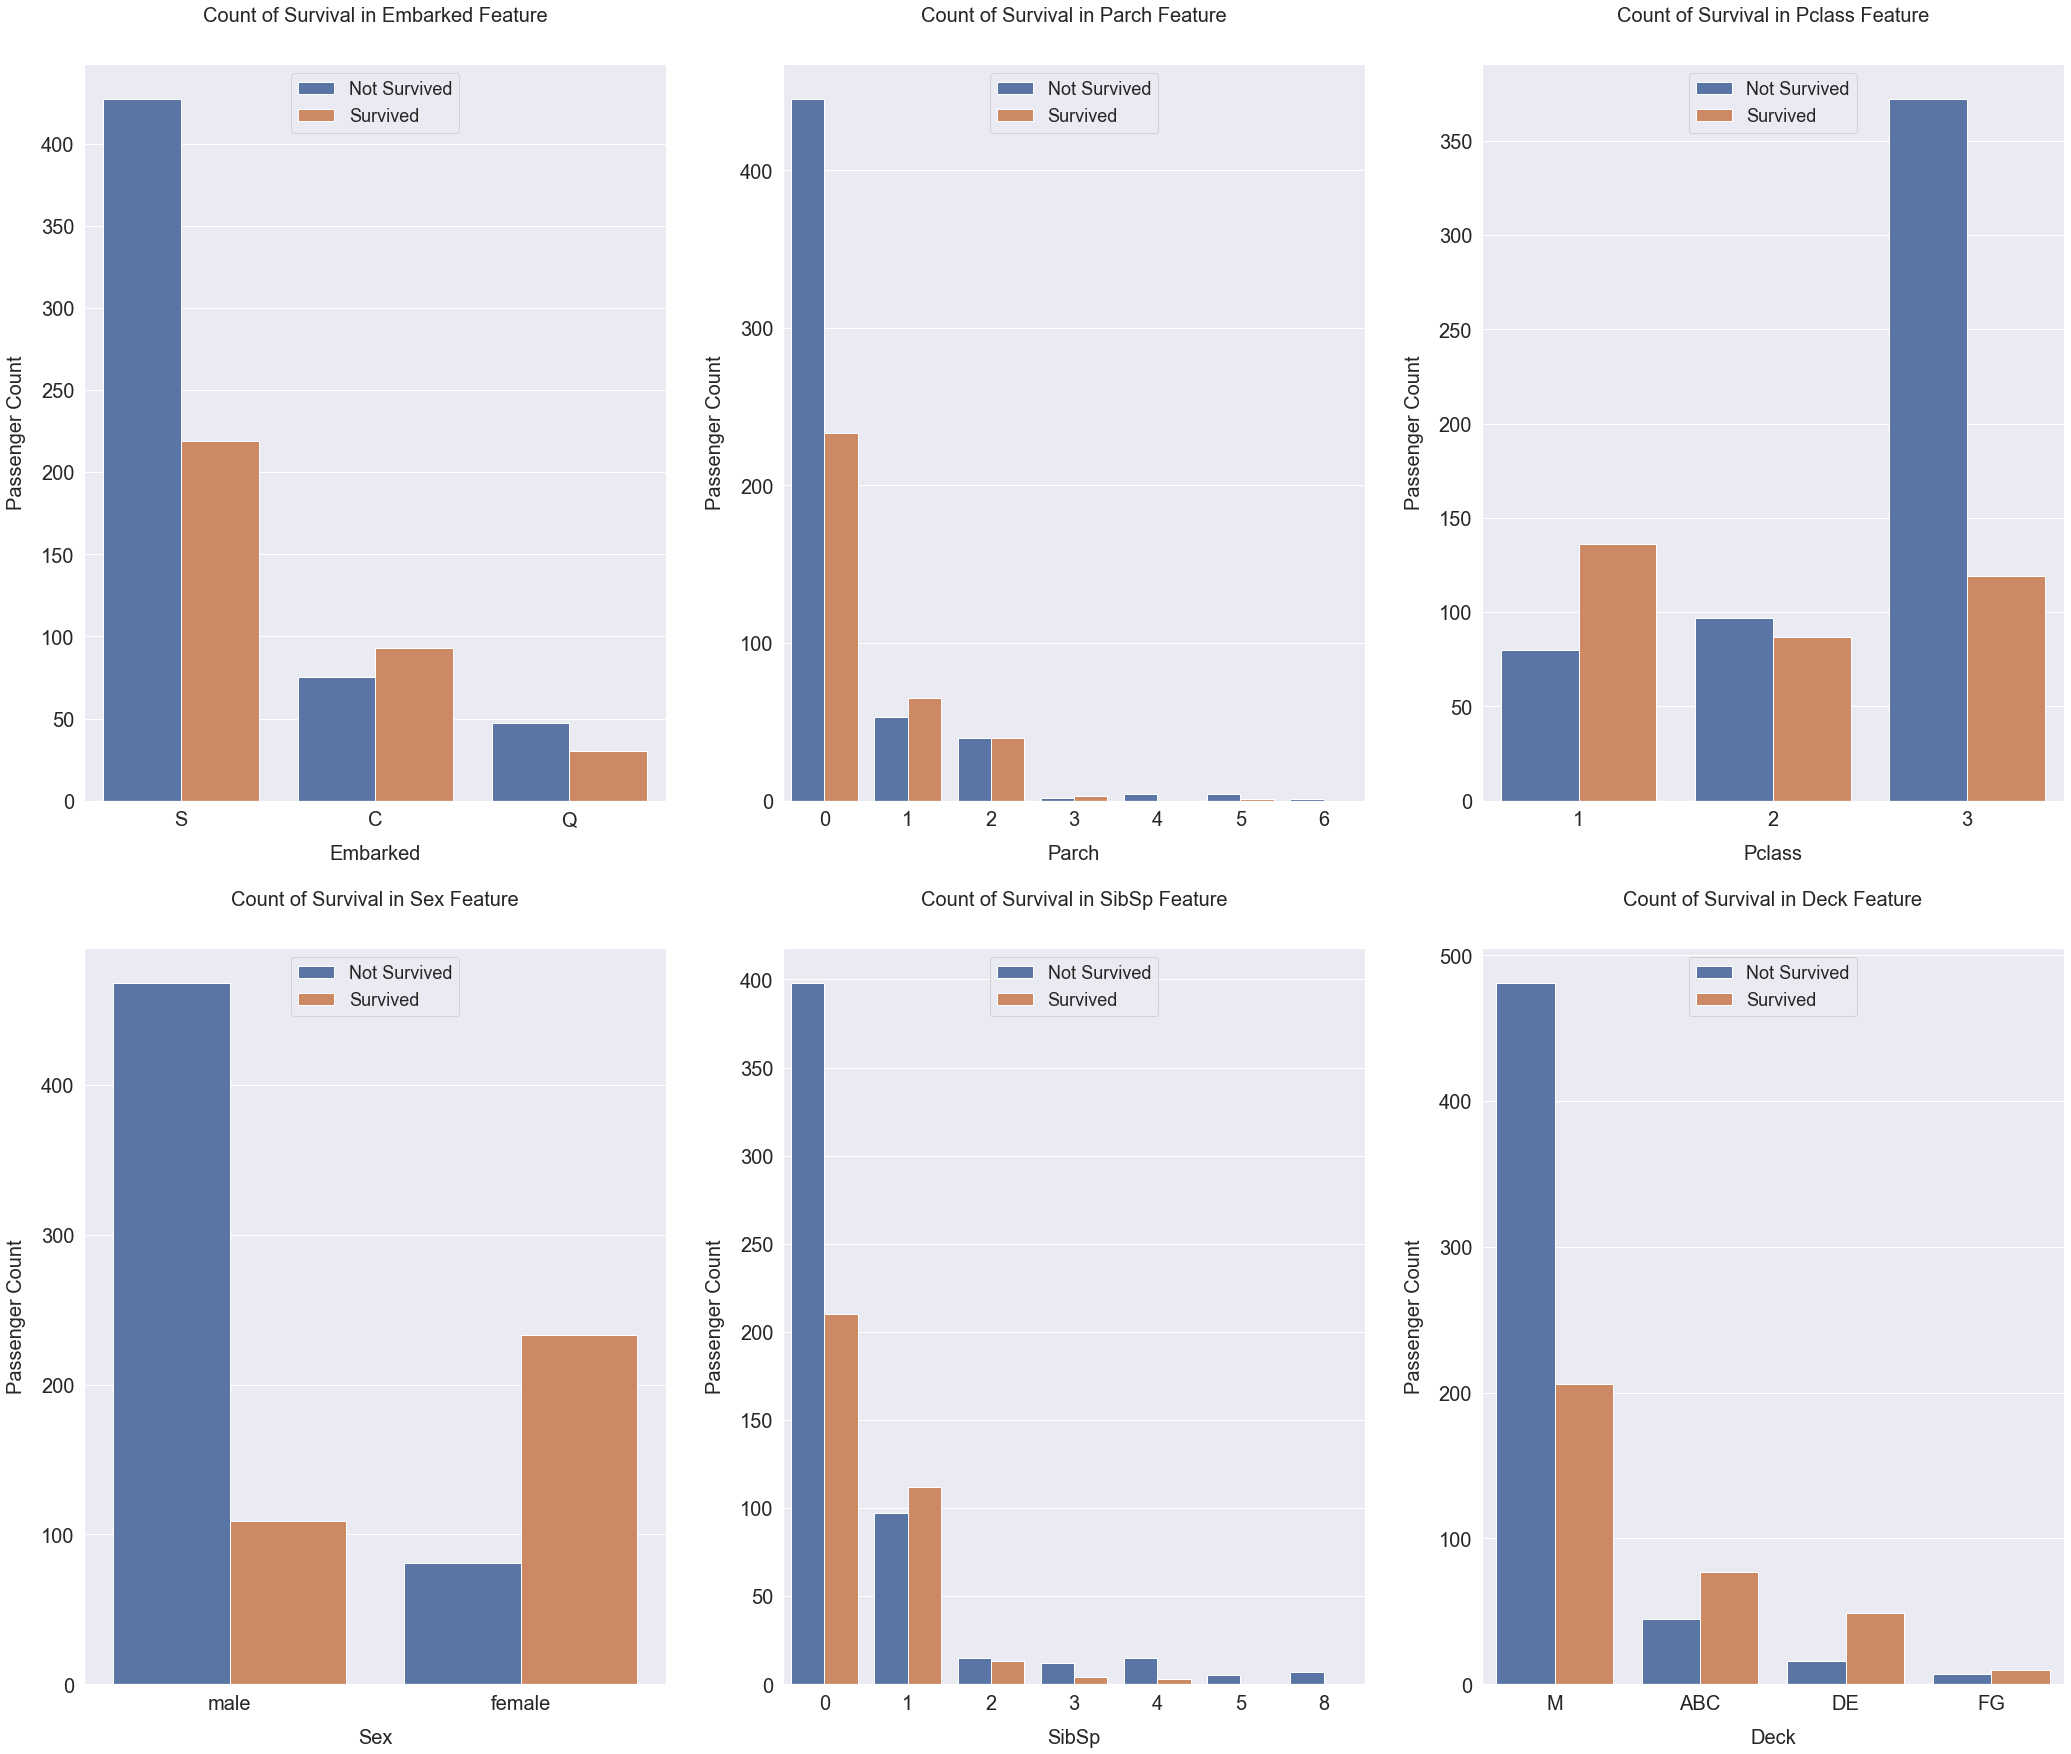

In [31]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

### **1.6 Conclusion**
几乎所有的特征都有些关联。这种关系可以用来构造出新的特征，方法有特征变换（feature transformation）和特征交互（feature interaction）。目标编码（Target Encoding）可能是一种非常有用的方法，因为它和 `Survived` 有高相关性。
连续型特征中的分割点和尖峰能够被决策树模型轻松地捕捉到，但是线性模型可能就识别不出来。
类别型特征有具有非常明显的分布和不同的幸存率。它们能够用独热编码（one-hot encoding），其中一些特征可能可以结合起来构造出新的特征。
我们之间就构造出新的特征 `Dect`, 丢弃原有的特征 `Cabin`。

> # 问题： 什么是独热编码（one-hot encoding），为什么要对类别型特征使用 one-hot encoding?
防止引入大小关系，无意义的大小关系(偏序关系)可能会被模型学习到，而且也会出现距离计算的问题，如 cat:0 dog:1, mouse:2, 所以 cat 离 dog 比离 mouse 更近？。
**树模型可能不太需要 one-hot encoding, 而且会增加树模型的深度。**

In [32]:
df_all = concat_df(df_train, df_test)
df_all.head()

Age Deck Embarked     Fare  \
0  22.0    M        S   7.2500   
1  38.0  ABC        C  71.2833   
2  26.0    M        S   7.9250   
3  35.0  ABC        S  53.1000   
4  35.0    M        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  
0       3    male      1       0.0         A/5 21171  
1       1  female      1       1.0          PC 17599  
2       3  female      0       1.0  STON/O2. 3101282  
3       1  female      1       1.0            113803  
4       3    male      0       0.0            373450

## **2. Feature Engineering**

### **2.1 Binning Continuous Features**

#### **2.1.1 Fare**
`Fare` 特征是正向倾斜的，右端的存活率非常高。`Fare` 特征基于13分位数进行分箱/分桶(bin。即使 bin 太多，它们也能提供相当多的信息增益。图左侧的组的幸存率最低，图右侧的组的幸存率最高。这种高幸存率在分布图中不可见。在这个过程中也有一个不寻常的群体 **（15.742，23.25）**，中间有很高的幸存率。

> # 为什么要分桶/分箱？好处是什么？
    对于连续型特征有以下好处
    1. 离散特征的增加和减少都很容易，易于模型的快速迭代；
    2. 稀疏向量内积乘法运算速度快，计算结果方便存储，容易扩展；
    3. 离散化后的特征对异常数据有很强的鲁棒性；
    4. 归属于广义线性模型，表达能力受限；单变量离散化为N个后，每个变量有单独的权重，相当于为模型引入了非线性，能够提升模型表达能力，加大拟合；
    5. 后可以进行特征交叉，由M+N个变量变为M*N个变量，进一步引入非线性，提升表达能力；
    6. 散化后，模型会更稳定，比如如果对用户年龄离散化，20-30作为一个区间，不会因为一个用户年龄长了一岁就变成一个完全不同的人。当然处于区间相邻处的样本会刚好相反，所以怎么划分区间是门学问；
    7. 特征离散化以后，起到了简化了逻辑回归模型的作用，降低了模型过拟合的风险。
    8. 可以将缺失作为独立的一类带入模型。
    9. 将所有变量变换到相似的尺度上。
    对于离散型（类别类型）特征的好处主要表现在：
    1. 增加模型的鲁棒性，减少模型过拟合

In [33]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

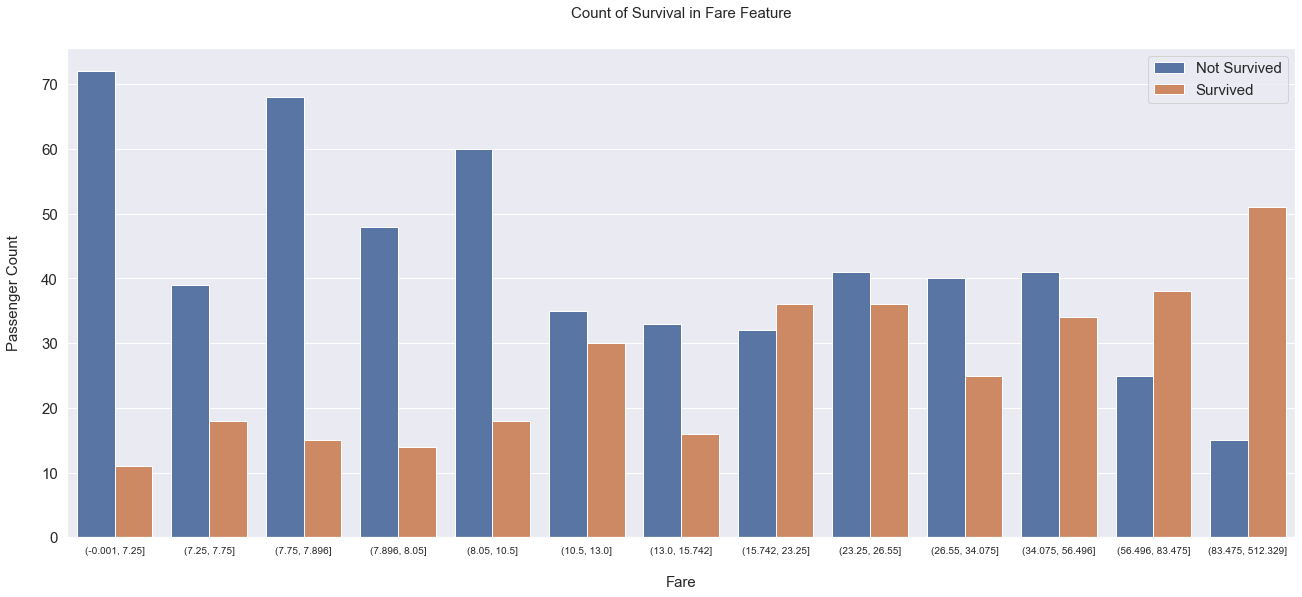

In [34]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### **2.1.2 Age**
`Age` 特征具有带有一些尖峰和颠簸的正态分布，并且基于 **10** 分位数的 bin 用于 `Age`。 第一个 bin 的存活率最高，第四个 bin 的幸存率最低。 发现还有一个不寻常的群体 **(34.0, 40.0]** 幸存率高。

In [35]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

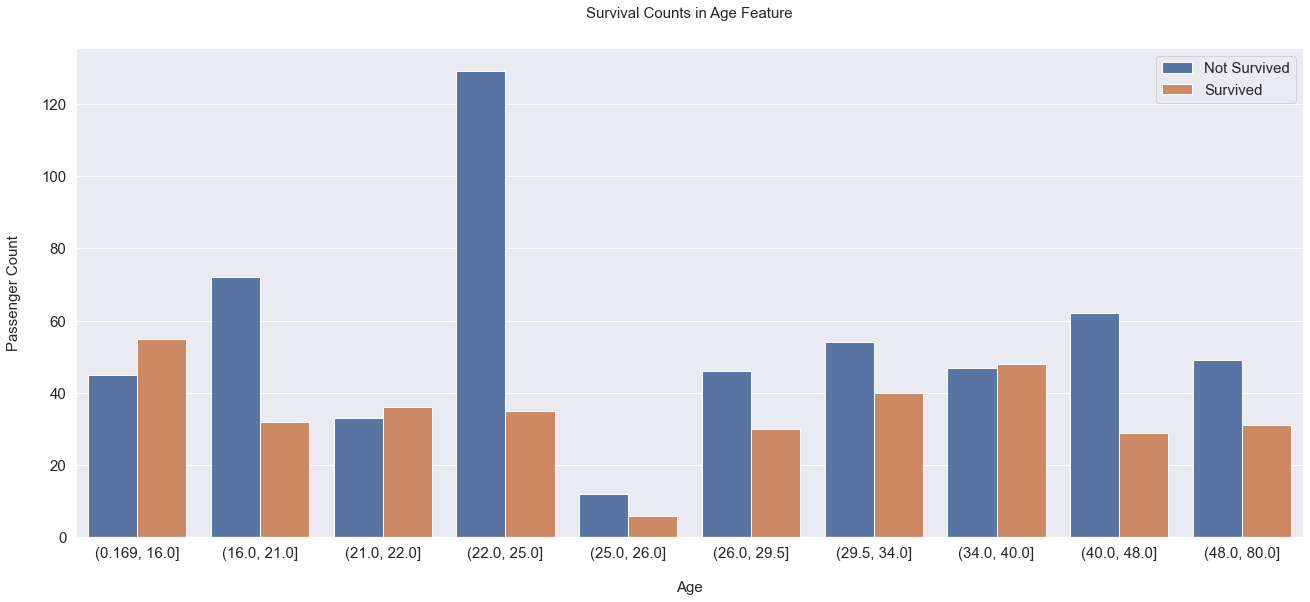

In [36]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### **2.2 Frequency Encoding**
`Family_Size` 是通过把`SibSp`和`Parch`相加后再加**1** 得到的。 `SibSp` 是兄弟姐妹和配偶的数量，而 `Parch` 是父母和孩子的数量。 加上这些列是为了计算家庭的总规模，最后加上**1**，就是当前的乘客。 图表清楚地表明，家庭规模是生存的预测指标，因为不同的值有不同的生存率。

* **1** 的家庭人数被标记为**Alone**
* **2**、**3** 和 **4** 的家庭规模被标记为**Small**
* **5** 和 **6** 的家庭规模被标记为**Medium**
* **7**、**8** 和 **11** 的家庭大小被标记为**Large**

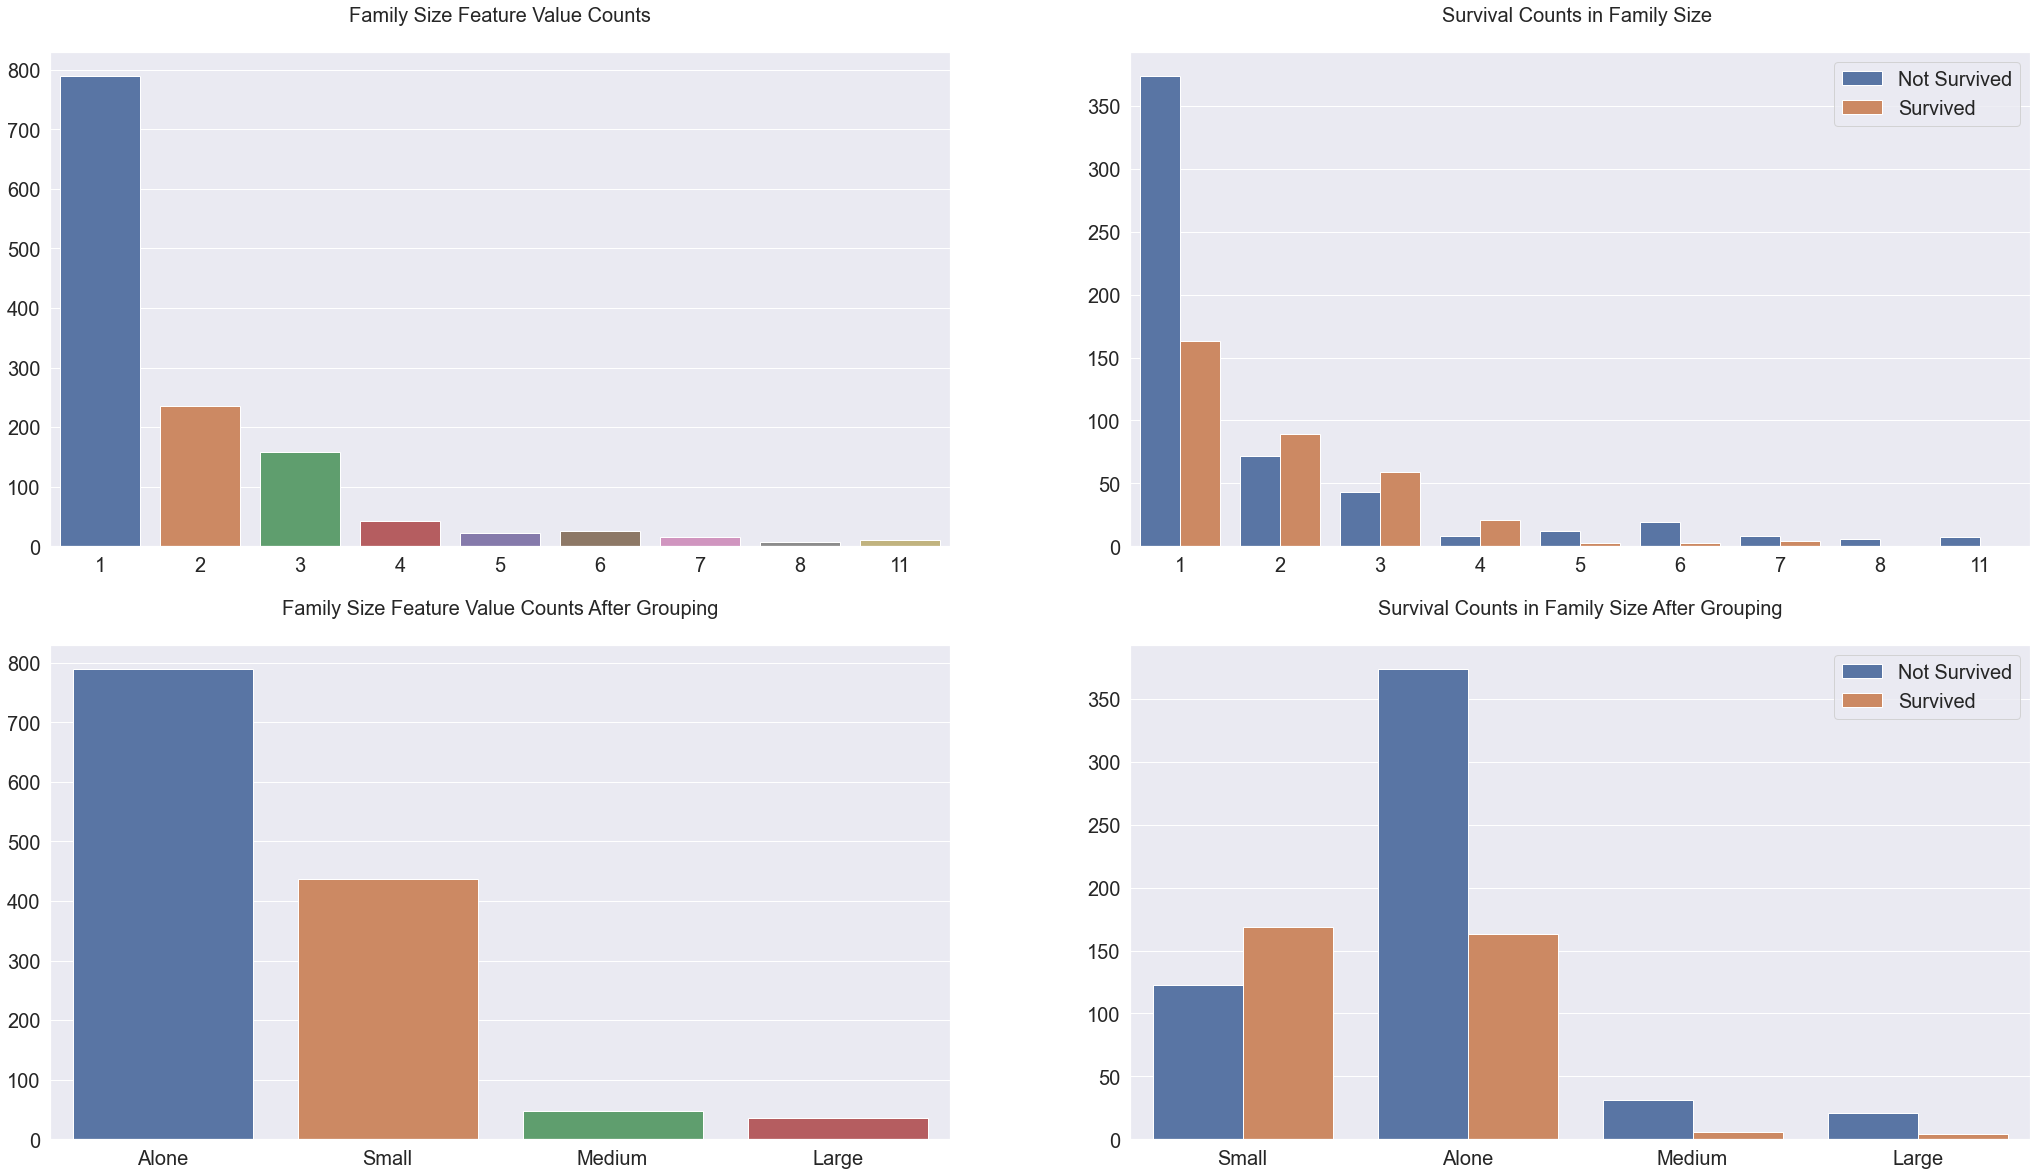

In [37]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

有太多唯一的`Ticket`值需要分析，因此将它们按频数分组会使事情变得更容易。

**此特征与 `Family_Size` 有何不同？** 许多乘客与团体一起旅行。这些团体由朋友、保姆、女佣等组成。他们不算作家人，但他们使用的是同一张票。

**为什么不按前缀对票进行分组？** 如果 `Ticket` 功能中的前缀有任何意义，那么它们已经在 `Pclass` 或 `Embarked` 功能中被捕获。

根据下图，拥有**2**、**3**和**4**成员的组的存活率更高。独自旅行的乘客存活率最低。 **4**组成员后，存活率急剧下降。此模式与“Family_Size”功能非常相似，但有细微差别。 `Ticket_Frequency` 值不像 `Family_Size` 那样分组，这样创建出来的特征不会提供任何额外的信息增益。

> # 为什么不像 Family_Size 那样分组，这样创建出来的特征不会提供任何额外的信息增益。
因为这样分组后，可能会和 family_size 的特征分布一模一样

In [38]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

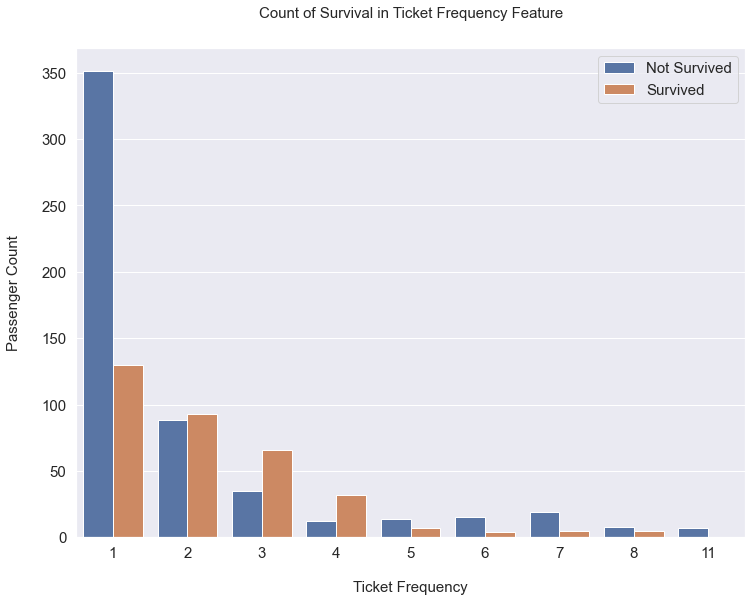

In [39]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### **2.3 Title & Is Married**
`Title` 是通过提取 `Name` 特征之前的前缀来创建的。根据下图，有很多`Title`出现的次数很少。其中一些`Title`似乎不正确，需要更换。 **Miss**、**Mrs**、**Ms**、**Mlle**、**Lady**、**Mme**、**the Countess**、**Dona**的`Title`是替换为 **Miss/Mrs/Ms** ，因为她们都是女性。 **Mlle**、**Mme** 和 **Dona** 等值实际上是乘客的姓名，但它们被归类为`Title`，因为 `Name` 特征被逗号分隔。 **Dr**、**Col**、**Major**、**Jonkheer**、**Capt**、**Sir**、**Don** 和 **Rev** 头衔被替换与**Dr/Military/Noble/Clergy**，因为这些乘客具有相似的特征。 **Master** 是一个独特的称号，授予 **26** 岁以下的男性乘客。在所有男性中，他们的存活率最高。
`Is_Married` 是基于 **Mrs** 头衔的二元特征。 **Mrs** 头衔在其他女性头衔中存活率最高。此`Title`必须是一个特征，因为所有女性`Title`都相互分组。

In [40]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

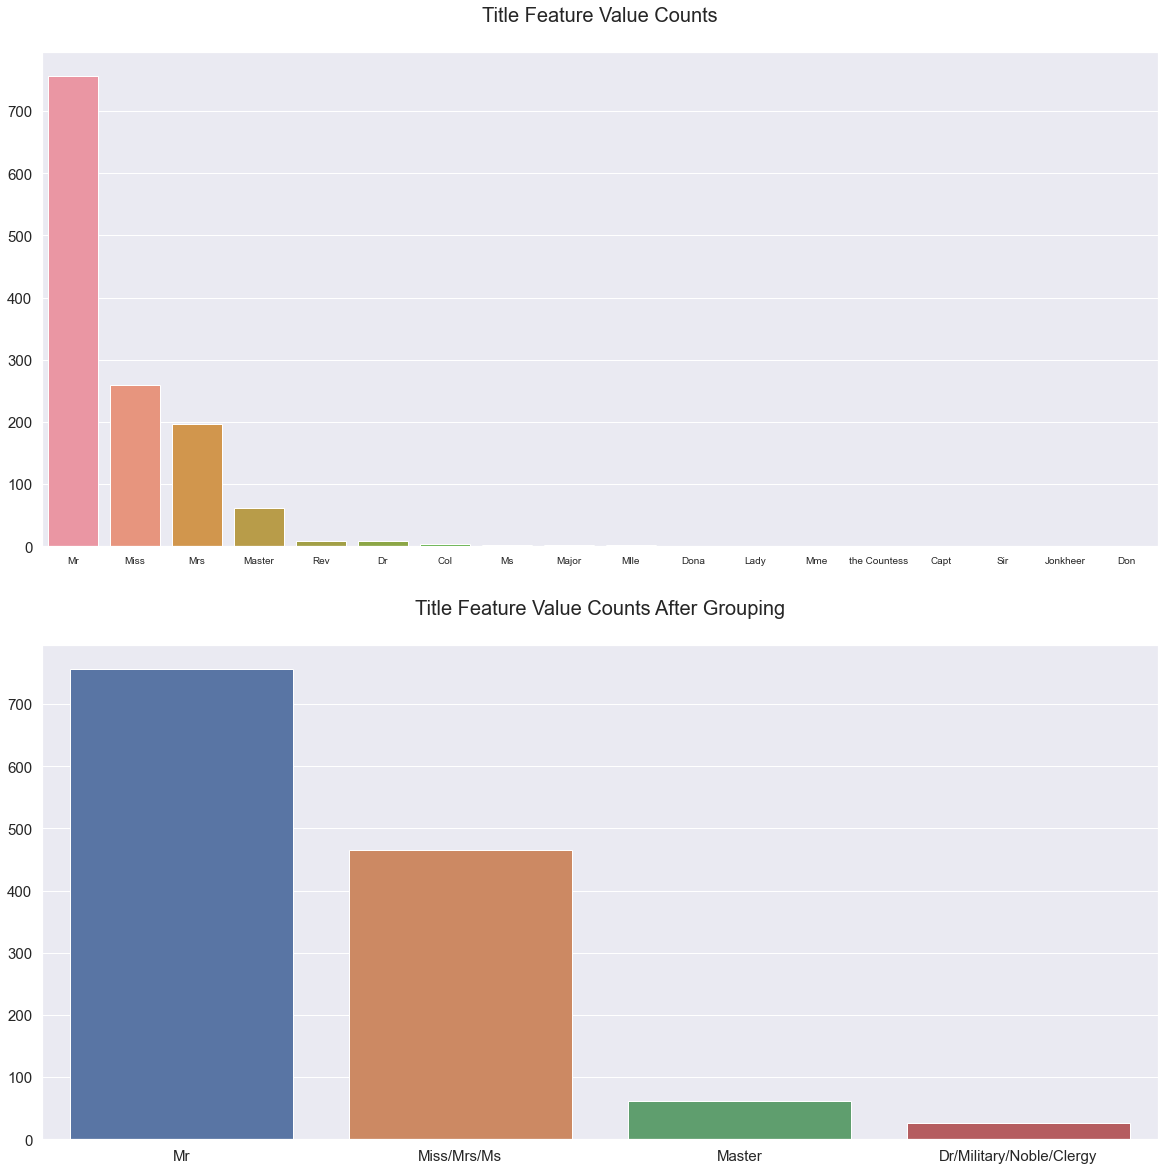

In [41]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### **2.4 Target Encoding**
`extract_surname` 函数用于从 `Name` 特征中提取乘客的姓氏。 `Family` 特征是使用提取的姓氏创建的。 这对于将同一家庭中的乘客分组是必要的。

In [42]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

`Family_Survival_Rate` 是根据训练集中的家庭计算得出的，因为测试集中没有 `Survived` 特征。创建了在训练集和测试集（`non_unique_families`）中出现的姓氏列表。幸存率是针对该列表中超过 1 个成员的家庭计算的，并存储在`Family_Survival_Rate`特征中。

为测试集独有的家庭创建了一个额外的二元特征`Family_Survival_Rate_NA`。这个功能也是必要的，因为没有办法计算这些家庭的幸存率。这个特征意味着家庭幸存率不适用于那些乘客，因为没有办法检索他们的幸存率。

`Ticket_Survival_Rate` 和 `Ticket_Survival_Rate_NA` 特征也使用相同的方法创建。 `Ticket_Survival_Rate` 和 `Family_Survival_Rate` 取平均值，变成 `Survival_Rate`，`Ticket_Survival_Rate_NA` 和 `Family_Survival_Rate_NA` 也求平均值，变成 `Survival_Rate_NA`。

In [43]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [44]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [45]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

### **2.5 Feature Transformation**

#### **2.5.1 Label Encoding Non-Numerical Features**
`Embarked`、`Sex`、`Deck`、`Title` 和`Family_Size_Grouped` 是对象类型，而`Age` 和`Fare` 特征是类别类型。 它们使用“LabelEncoder”转换为数字类型。 `LabelEncoder` 基本上标记了从 **0** 到 **n** 的类。 这个过程对于模型从这些特征中学习是必要的。

Pandas 类型
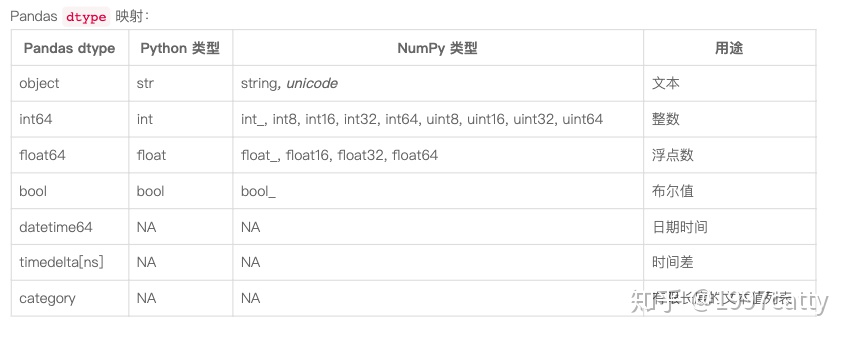

In [46]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

#### **2.5.2 One-Hot Encoding the Categorical Features**
分类特征（`Pclass`、`Sex`、`Deck`、`Embarked`、`Title`）通过`OneHotEncoder` 转换为one-hot 编码特征。 `Age` 和 `Fare` 特征不会被转换，因为它们与其他的不同，它们是有序的（大小关系）。

In [47]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

### **2.6 Conclusion**
`Age` 和 `Fare` 特征被合并。 分箱有助于处理异常值，它揭示了这些特征中的一些同质组。 `Family_Size` 是通过把 `Parch` 和 `SibSp` 特征相加再加 **1** 创建的。`Ticket_Frequency` 是通过计算 `Ticket` 值的出现次数来创建的。

`Name` 特征非常有用。 首先，`Title` 和 `Is_Married` 特征是根据`Name`中的`Title`前缀创建的。 其次，`Family_Survival_Rate` 和`Family_Survival_Rate_NA` 特征是通过对乘客姓氏进行目标编码(Target Encoding)来创建的。 `Ticket_Survival_Rate` 是通过目标编码 `Ticket` 功能创建的。 `Survival_Rate` 特征是通过对 `Family_Survival_Rate` 和 `Ticket_Survival_Rate` 特征求平均值来创建的。

最后，对非数字类型特征进行标签编码，对分类特征进行单热编码。 创建了 **5** 个新特性（`Family_Size`、`Title`、`Is_Married`、`Survival_Rate` 和 `Survival_Rate_NA`）并在编码后删除了无用的特性。

In [48]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

Age  Deck_1  Deck_2  Deck_3  Deck_4  Embarked_1  Embarked_2  Embarked_3  \
0    2     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
1    7     1.0     0.0     0.0     0.0         1.0         0.0         0.0   
2    4     0.0     0.0     0.0     1.0         0.0         0.0         1.0   
3    7     1.0     0.0     0.0     0.0         0.0         0.0         1.0   
4    7     0.0     0.0     0.0     1.0         0.0         0.0         1.0   

   Family_Size_Grouped_1  Family_Size_Grouped_2  ...  Pclass_3  Sex_1  Sex_2  \
0                    0.0                    0.0  ...       1.0    0.0    1.0   
1                    0.0                    0.0  ...       0.0    1.0    0.0   
2                    1.0                    0.0  ...       1.0    1.0    0.0   
3                    0.0                    0.0  ...       0.0    1.0    0.0   
4                    1.0                    0.0  ...       1.0    0.0    1.0   

   Survival_Rate  Survival_Rate_NA  Ticket_Frequency  Title_1  Title_2  \
0       0.383838               0.0                 1      0.0      0.0   
1       1.000000               1.0                 2      0.0      0.0   
2       0.383838               0.0                 1      0.0      0.0   
3       0.383838               0.0                 2      0.0      0.0   
4       0.383838               0.0                 1      0.0      0.0   

   Title_3  Title_4  
0      0.0      1.0  
1      1.0      0.0  
2      1.0      0.0  
3      1.0      0.0  
4      0.0      1.0  

[5 rows x 26 columns]

## **3. Model**

In [49]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


### **3.1 Random Forest**
创建了 2 个`RandomForestClassifier`。 其中一个是单个模型，另一个用于 k 折交叉验证。

`single_best_model` 在公开排行榜中的最高准确率为 **0.82775**。 但是，它在 k 折交叉验证中的表现并不好。 这是开始试验和超参数调整的好模型。

`leaderboard_model` 在公共排行榜中的最高准确率为 **0.83732**，采用 5 折交叉验证。 这个模型是为排行榜得分而创建的，它被调整为稍微过拟合。 它被设计为过拟合，因为每个 Fold 中`X_test` 的估计概率将除以 **N**（Fold 计数）。 如果将此模型用作单个模型，则很难正确预测大量样本。

**应该使用哪种类型？**
* `leaderboard_model` 过拟合测试集，所以不建议在现实生活项目中使用这样的模型。
* `single_best_model` 是开始试验和学习决策树的好模型。

In [50]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

`StratifiedKFold` 用于对目标变量进行分层。 这种产生 Fold 的策略是通过保留目标变量（`Survived`）中每个类的样本百分比来进行的。

In [51]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 1 OOB Score: 0.8553370786516854

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 2 OOB Score: 0.844319775596073

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 3 OOB Score: 0.8513323983169705

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 4 OOB Score: 0.8359046283309958

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 5 OOB Score: 0.8260869565217391

Average OOB Score: 0.8425961674834928


[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.3s finished


### **3.2 Feature Importance**

> # 问题：特征重要性是怎么来的
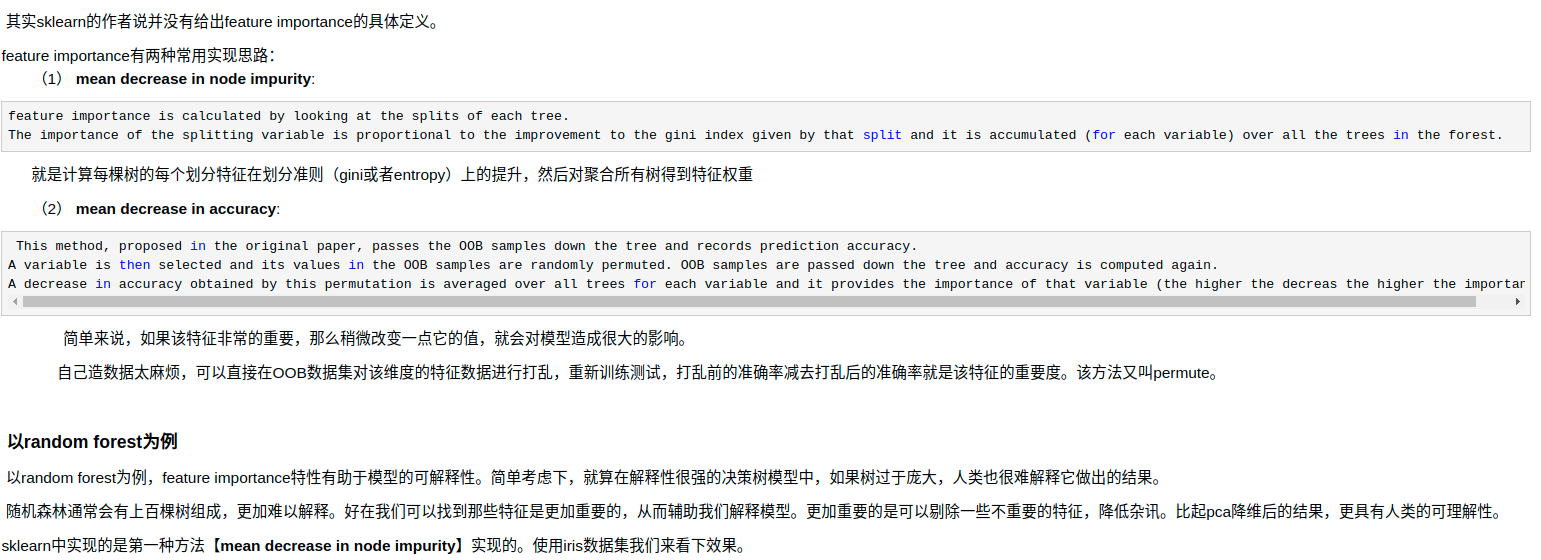
参考链接：https://www.cnblogs.com/wqbin/p/12803594.html

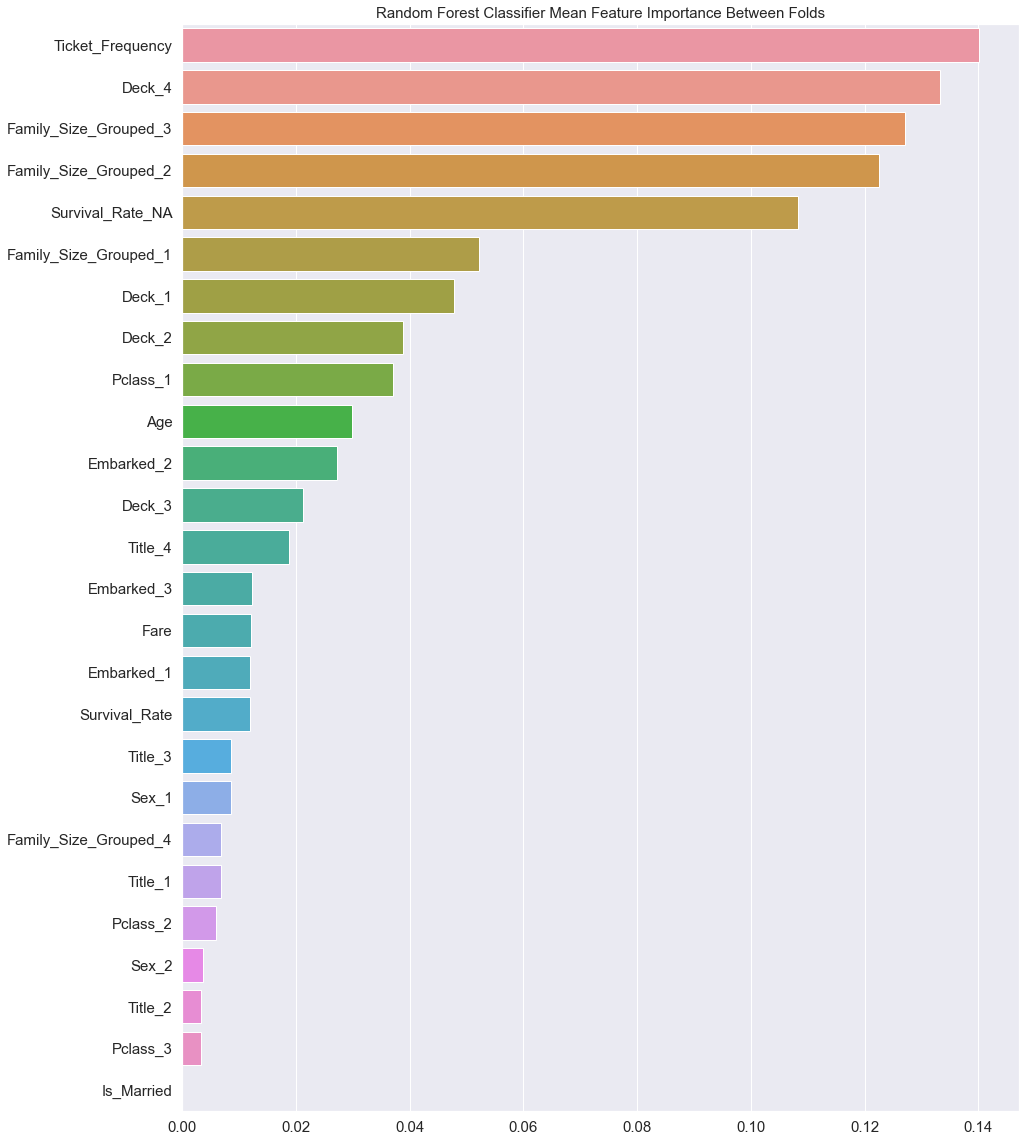

In [52]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

### **3.3 ROC Curve**

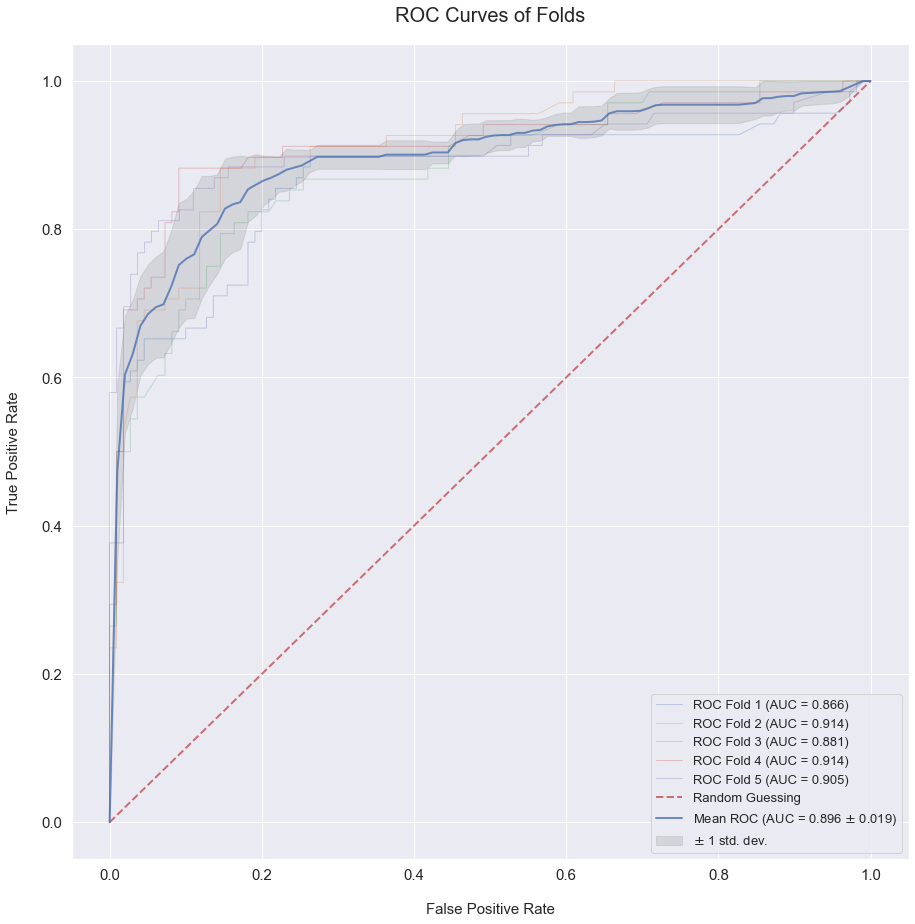

In [53]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

### **3.4 Submission**

In [54]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

PassengerId  Survived
891          892         0
892          893         1
893          894         0
894          895         0
895          896         1
896          897         0
897          898         1
898          899         0
899          900         1
900          901         0